In [1]:
# Imports
import numpy as np 
import pandas as pd 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import re
import itertools
%matplotlib inline
from IPython.display import Audio
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
import os
print(tf.test.gpu_device_name())

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
# # Paths for data to create the dataset.

# Ravdess = "C:\\Users\\ashee\\Documents\\Emotion dataset\\Ravdess\\audio_speech_actors_01-24\\"
# Crema = "C:\\Users\\ashee\\Documents\\Emotion dataset\\Crema\\"
# Tess = "C:\\Users\\ashee\\Documents\\Emotion dataset\\Tess\\"
# Savee = "C:\\Users\\ashee\\Documents\\Emotion dataset\\Savee\\"

In [3]:
# print("Getting the dataset..................")
# savee_data=[]
# for wav in os.listdir(Savee):
#     emotion=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
#     emotion=re.split(r'[0-9]',emotion)[0]
#     if emotion=='a':
#         savee_data.append(('angry',Savee+'/'+wav))
#     elif emotion=='d':
#         savee_data.append(('disgust',Savee+'/'+wav))
#     elif emotion=='f':
#         savee_data.append(('fear',Savee+'/'+wav))
#     elif emotion=='h':
#         savee_data.append(('happy',Savee+'/'+wav))
#     elif emotion=='n':
#         savee_data.append(('neutral',Savee+'/'+wav))
#     elif emotion=='sa':
#         savee_data.append(('sad',Savee+'/'+wav))
#     elif emotion=='su':
#         savee_data.append(('surprise',Savee+'/'+wav))
# Savee_df=pd.DataFrame.from_dict(savee_data)
# Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)

In [4]:
# crema_data=[]
# for wav in os.listdir(Crema):
#     emotion=wav.partition(".wav")[0].split('_')
#     if emotion[2]=='SAD':
#         crema_data.append(('sad',Crema+'/'+wav))
#     elif emotion[2]=='ANG':
#         crema_data.append(('angry',Crema+'/'+wav))
#     elif emotion[2]=='DIS':
#         crema_data.append(('disgust',Crema+'/'+wav))
#     elif emotion[2]=='FEA':
#         crema_data.append(('fear',Crema+'/'+wav))
#     elif emotion[2]=='HAP':
#         crema_data.append(('happy',Crema+'/'+wav))
#     elif emotion[2]=='NEU':
#         crema_data.append(('neutral',Crema+'/'+wav))
#     else:
#         crema_data.append(('unknown',Crema+'/'+wav))
# Crema_df=pd.DataFrame.from_dict(crema_data)
# Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)

In [5]:
# tess_data=[]
# for directory in os.listdir(Tess):
#     for wav in os.listdir(os.path.join(Tess,directory)):
#         emotion=wav.partition('.wav')[0].split('_')
#         if emotion[2]=='ps':
#             tess_data.append(('surprise',os.path.join(Tess,directory,wav)))
#         else:
#             tess_data.append((emotion[2],os.path.join(Tess,directory,wav)))
# Tess_df=pd.DataFrame.from_dict(tess_data)
# Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)

In [6]:
# ravdess_data=[]
# for directory in os.listdir(Ravdess):
#     actor=os.listdir(os.path.join(Ravdess,directory))
#     for wav in actor:
#         emotion=wav.partition('.wav')[0].split('-')
#         emotion_number=int(emotion[2])
#         ravdess_data.append((emotion_number,os.path.join(Ravdess,directory,wav)))
# Ravdess_df=pd.DataFrame.from_dict(ravdess_data)
# Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
# Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)

In [7]:
# Getting the dataset from running the above code

# emotions_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
# emotions_df.to_csv('Emotions_dataset.csv',index=False)
# print('Dataset shape: ', emotions_df.shape)
# # print(emotions_df.head(10))
# print('Emotions in dataset: ', emotions_df['Emotion'].unique())

In [8]:
#Visualizing the dataset emotion counts

# plt.figure(figsize=(12,7))
# plt.title('Visualization of emotions count for the Speech Emotion Recognition dataset')
# data_visualization=sns.countplot(x='Emotion',data=emotions_df,palette='Set1')
# data_visualization.set_xticklabels(data_visualization.get_xticklabels(),rotation=45)
# plt.show()

In [9]:
# emotion_names=emotions_df['Emotion'].unique()
# #print(emotion_names)

In [2]:
# data augmentation techniques

def noise_injection(audio,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(audio)
    augmented_data=audio+noise*np.random.normal(size=audio.shape[0])
    return augmented_data

def time_shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitch_changing(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data,sr,pitch_factor)

In [11]:
# # Visualizing data augmentation techniques.
# audio_path = np.array(emotions_df.File_Path)[1]
# data, sr = librosa.load(audio_path)


In [12]:
# # Original audio sample
# plt.figure(figsize=(12,3))
# plt.title("Original audio sample")
# librosa.display.waveshow(y=data, sr=sr)

In [13]:
# # Noise injected audio
# noise_injected = noise_injection(data)
# plt.figure(figsize=(12,3))
# plt.title("Noise injected audio")
# librosa.display.waveshow(y=noise_injected, sr=sr)

In [14]:
# # Pitch changed data
# pitch_changed=pitch_changing(data,sr,random=True)
# plt.figure(figsize=(12,3))
# plt.title("Pitch changed audio")
# librosa.display.waveshow(y=pitch_changed, sr=sr)

In [3]:
# Feature extraction techniques

def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmsv(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmsv(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,dur=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=dur,offset=offset)
    audio=extract_features(data,sr)
    audio=np.array(audio)
    
    noise_injected_audio=noise_injection(data,random=True)
    audio2=extract_features(noise_injected_audio,sr)
    audio=np.vstack((audio,audio2))
    
    pitch_changed_audio=pitch_changing(data,sr,random=True)
    audio3=extract_features(pitch_changed_audio,sr)
    audio=np.vstack((audio,audio3))
    
    pitched_audio=pitch_changing(data,sr,random=True)
    noise_injected_pithced_audio=noise_injection(pitched_audio,random=True)
    audio4=extract_features(noise_injected_pithced_audio,sr)
    audio=np.vstack((audio,audio4))
    
    return audio

In [16]:
# Perform feature extraction and data augmentation to get feature vector

# print('Extracting the audio features and applying data augmentation..................')
# X,Y=[],[]
# for path,emotion,index in zip(emotions_df.File_Path,emotions_df.Emotion,range(emotions_df.File_Path.shape[0])):
#     features=get_features(path)
#     if index%500==0:
#         print(f'{index} audio samples completed')
#     for i in features:
#         X.append(i)
#         Y.append(emotion)
# print('Done')

In [17]:
#Save feature vector

# from enum import unique
# extract=pd.DataFrame(X)
# extract['Emotion']=Y
# extract.to_csv('features.csv',index=False)
# extract.head(10)
# extract['Emotion'].unique()

In [4]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Root path of feature vector
root_path = '/content/drive/My Drive/features.csv'

In [6]:
# Load feature vector from google drive
df=pd.read_csv(root_path)
df.shape

(48648, 2377)

In [7]:
# Remove null values
df=df.fillna(0)
# print(df.isna().any())

In [8]:
# Split data into features and labels
X=df.drop(labels='Emotion',axis=1)
print("Feature vector shape: ", X.shape)
Y=df.Emotion.values


Feature vector shape:  (48648, 2376)


In [23]:
# MLP

In [24]:
# Split data into test,train splits
print("Setting up the MLP model..............")
X_scaled =  StandardScaler().fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,test_size = 0.2, random_state=42)

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

# Train the model
print("Beginning MLP training...........")
model.fit(X_train,y_train)

Setting up the MLP model..............
Beginning MLP training...........


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [25]:
# Predict for the test set
y_pred=model.predict(X_test)

# Calculate the accuracy of the model
accuracy=accuracy_score(y_test,y_pred)

print("Accuracy of MLP: {:.2f}%".format(accuracy*100))

Accuracy of MLP: 77.02%


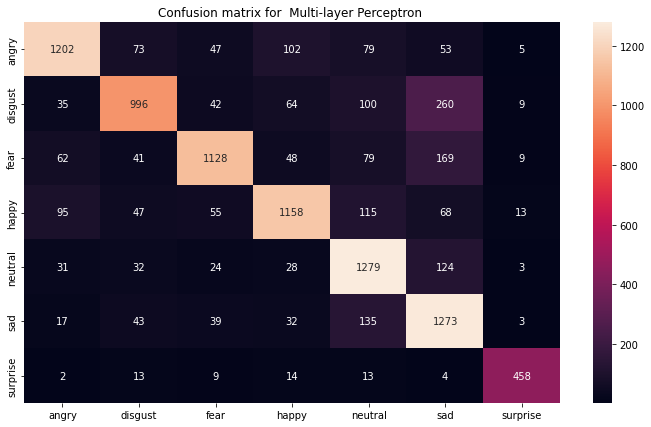

In [26]:
# Plot confusion matrix

emotion_names = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for  Multi-layer Perceptron ')
plt.show()

In [27]:
#kNN

In [28]:
# Split data into test,train splits
print("Setting up the kNN model..............")
X_scaled =  StandardScaler().fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,test_size = 0.2, random_state=42)

# Initialize the kNN
knn_model = KNN(n_neighbors = 1, metric = 'minkowski', p = 2)

# Train the model
print("Beginning kNN training...........")
knn_model.fit(X_train, y_train)

Setting up the kNN model..............
Beginning kNN training...........


KNeighborsClassifier(n_neighbors=1)

In [29]:
# Make predications on test set
y_pred = knn_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test,y_pred)

print("Accuracy of kNN: {:.2f}%".format(accuracy*100))

Accuracy of kNN: 84.16%


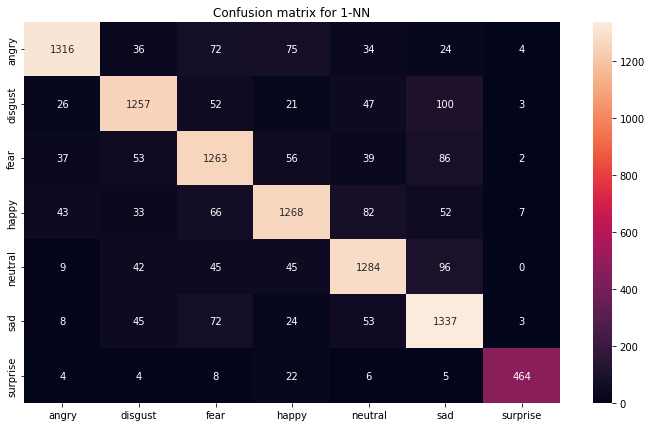

In [30]:
# Plot confusion matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
# print(confusion_matrix)

emotion_names = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')

cm=pd.DataFrame(
    confusion_matrix,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for 1-NN')
plt.show()

In [31]:
# RFC

In [44]:
# Split data into test,train splits
print("Setting up the RFC model..............")
X_scaled =  StandardScaler().fit_transform(X) 
X_train, X_valid, y_train, y_test = train_test_split(X_scaled,Y,test_size = 0.2, random_state=42)

# Initialize the RFC
RFC_model = RandomForestClassifier(n_estimators=300)

Setting up the RFC model..............


In [45]:
# Train the model
print("Beginning RFC training...........")
RFC_model.fit(X_train,y_train)

Beginning RFC training...........


RandomForestClassifier(n_estimators=300)

In [46]:
# Make predictions
y_pred = RFC_model.predict(X_valid) 

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test,y_pred) 

print("Accuracy of RFC: {:.2f}%".format(accuracy*100))

Accuracy of RFC: 80.90%


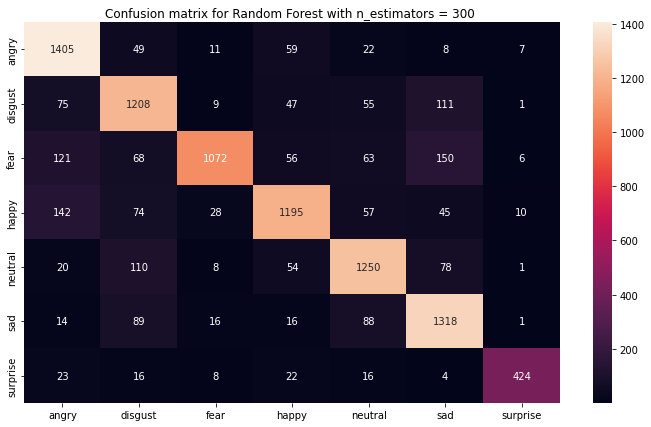

In [48]:
# Plot confusion matrix

emotion_names = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for Random Forest with n_estimators = 300 ')
plt.show()

In [49]:
# SVM

In [9]:
# Split data into test,train splits
print("Setting up the SVM model..............")
X_scaled =  StandardScaler().fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,test_size = 0.2, random_state=42)

# Initialize the SVM
SVM_model = svm.SVC()

Setting up the SVM model..............


In [55]:
# hyperparameter tuning

In [56]:
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(X_train, y_train)

In [57]:
# # print best parameter after tuning
# print(grid.best_params_)
  
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)

In [58]:
# grid_predictions = grid.predict(X_test)
  
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [59]:
# # Plot confusion matrix

# import matplotlib.pyplot as plt
# emotion_names = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')
# conf=confusion_matrix(y_test,grid_predictions)
# cm=pd.DataFrame(
#     conf,index=[i for i in emotion_names],
#     columns=[i for i in emotion_names]
# )
# plt.figure(figsize=(12,7))
# ax=sns.heatmap(cm,annot=True,fmt='d')
# ax.set_title(f'Confusion matrix for Support Vector Machine')
# plt.show()

In [60]:
# Normal svm

In [10]:
# Train the model
print("Beginning SVM training...........")
SVM_model.fit(X_train, y_train)

Beginning SVM training...........


SVC()

In [11]:
# Make predictions
y_pred = SVM_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test,y_pred) 

print("Accuracy of SVM: {:.2f}%".format(accuracy*100))


Accuracy of SVM: 61.20%


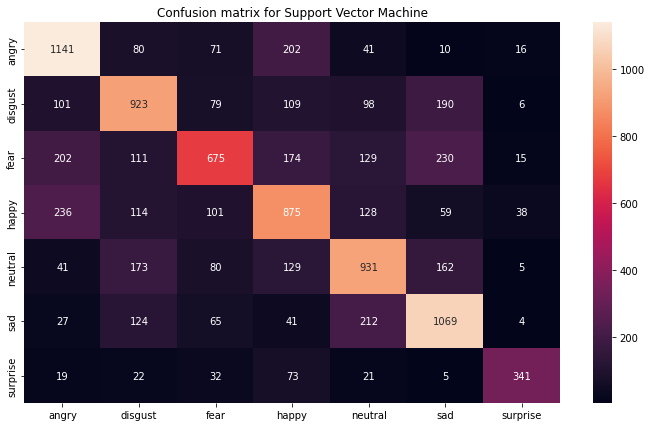

In [12]:
# Plot confusion matrix

import matplotlib.pyplot as plt
emotion_names = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for Support Vector Machine')
plt.show()

In [13]:
# CNN
print("Setting up the CNN model")

Setting up the CNN model


In [14]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [15]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=42,test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [16]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [17]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [18]:
early_stoppage=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [19]:
EPOCHS=15
BATCH_SIZE=64

In [20]:
# Build model architecture
CNN_model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
CNN_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
CNN_model.summary()
from keras.utils.vis_utils import plot_model
# plot_model(CNN_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                        

In [ ]:
# Train model
print("Beginning CNN training...........")
history=CNN_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test,y_test), batch_size=BATCH_SIZE,callbacks=[early_stoppage,learning_rate_reduction])

In [ ]:
# # Save model
# model_path = "emotion_classification_model_29oct_16_00_15epochs.h5"

# CNN_model.save(model_path)

In [22]:
# Load pretrained CNN model from google drive
CNN_model = tf.keras.models.load_model('/content/drive/My Drive/emotion_classification_model_20oct_21_00_15epochs.h5')

In [ ]:
# # Load pretrained CNN model from customer location
# CNN_model = tf.keras.models.load_model('')

In [23]:
y_pred = CNN_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

305/305 [==============================] - 14s 45ms/step


array([0, 5, 2, ..., 4, 4, 5])

In [24]:
y_check=np.argmax(y_test,axis=1)
y_check

array([0, 5, 2, ..., 4, 4, 5])

In [25]:
loss,accuracy=CNN_model.evaluate(X_test,y_test,verbose=1)
print("Loss of CNN: {:.2f}%".format(loss*100))
print("Accuracy of CNN: {:.2f}%".format(accuracy*100))

305/305 [==============================] - 15s 47ms/step - loss: 0.2358 - accuracy: 0.9270
Loss of CNN: 23.58%
Accuracy of CNN: 92.70%


In [26]:
Emotions = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')

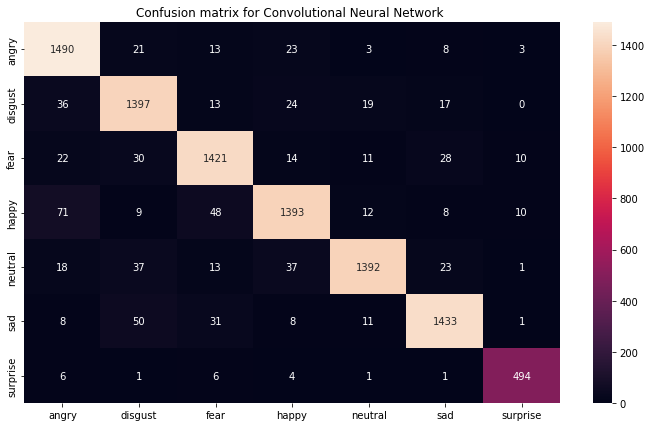

In [27]:
emotion_names = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],dtype='object')
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for Convolutional Neural Network ')
plt.show()

In [29]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

       angry       0.90      0.95      0.93      1561
     disgust       0.90      0.93      0.92      1506
        fear       0.92      0.93      0.92      1536
       happy       0.93      0.90      0.91      1551
     neutral       0.96      0.92      0.94      1521
         sad       0.94      0.93      0.94      1542
    surprise       0.95      0.96      0.96       513

    accuracy                           0.93      9730
   macro avg       0.93      0.93      0.93      9730
weighted avg       0.93      0.93      0.93      9730



In [ ]:
# Testing the CNN model

In [33]:
# path of audio sample to test
path = '/content/drive/My Drive/Happy(1).wav'
IPython.display.Audio(path)

In [ ]:
# Feature extraction
X,Y = [],[]

features = get_features(path)
for i in features:
    X.append(i)
    Y.append('angry')
X =pd.DataFrame(X)
X.shape

# reshape to suite model
row,col = X.shape
for i in range (col,2376):
  X[i]=0
X.shape

X = X.to_numpy()
X_test = scaler.transform(X[1].reshape(1,-1))

test_input = np.expand_dims(X_test, axis=2)

# Make prediction
pred_test= CNN_model.predict(test_input)

y_pred= encoder.inverse_transform(pred_test)

print("Emotion conveyed in audio sample: ",y_pred[0][0])